# Data labeling
This notebook shows how to conduct data labeling and content analysis using [EDSL](https://docs.expectedparrot.com), an open-source library for simulating surveys, experiments and other research with AI agents and large language models. 

Using a dataset of mock customer service tickets as an example, we demonstrate how to: 

1. Import data into EDSL 
2. Create questions about the data 
3. Design an AI agent to answer the questions
4. Select a language model to generate responses
5. Analyze results as a formatted dataset

This workflow can be visualized as follows:
<br><br>
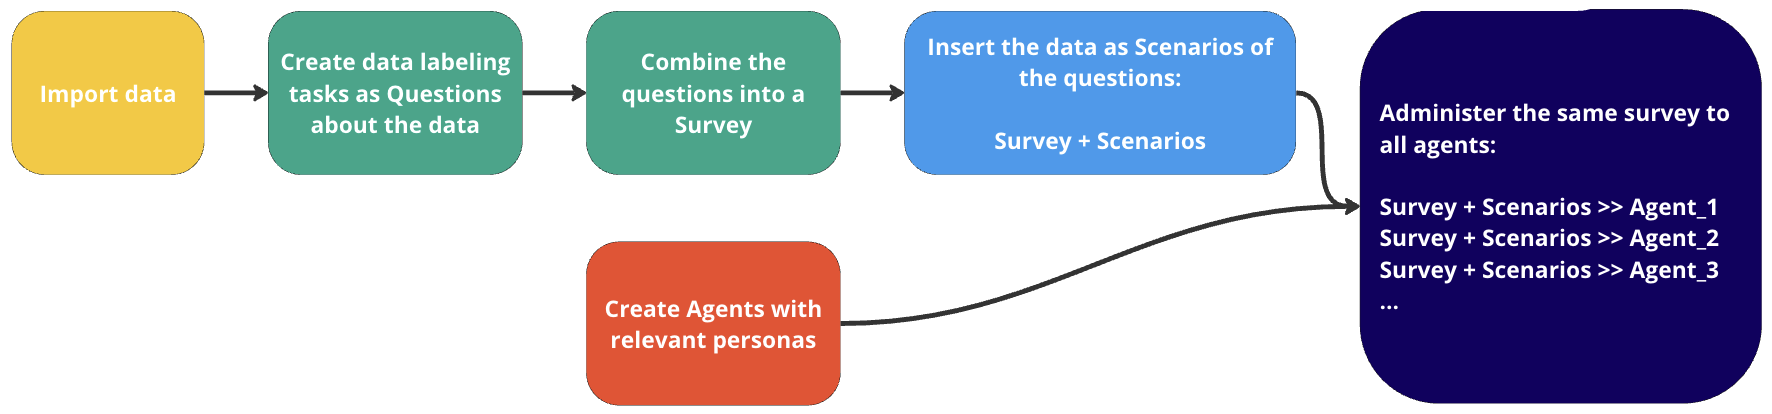
<br><br>

## Technical setup
Before running the code below please ensure that you have completed setup:

* [Install EDSL](https://docs.expectedparrot.com/en/latest/installation.html).
* Create a [Coop account](https://www.expectedparrot.com/login) and activate [remote inference](https://docs.expectedparrot.com/en/latest/remote_inference.html) OR store your own [API Keys](https://docs.expectedparrot.com/en/latest/api_keys.html) for language models that you want to use.

Our [Starter Tutorial](https://docs.expectedparrot.com/en/latest/starter_tutorial.html) also provides examples of EDSL basic components. 

## Selecting data for review
First we identify some data for review. Data can be created using the EDSL tools or imported from other sources. For purposes of this demo we import a set of hypothetical customer tickets for a transportation app:

In [1]:
tickets = [
    "I just realized I left my phone in the car on my last ride. Can you help me get it back?",
    "I'm unhappy with my recent experience. The driver was very rude and unprofessional.",
    "I was charged more than the estimated fare for my trip yesterday. Can you explain why?",
    "The car seat provided was not properly installed, and I felt my child was at risk. Please ensure driver training.",
    "My driver took a longer route than necessary, resulting in a higher fare. I request a fare adjustment.",
    "I had a great experience with my driver today! Very friendly and efficient service.",
    "I'm concerned about the vehicle's cleanliness. It was not up to the standard I expect.",
    "The app keeps crashing every time I try to book a ride. Please fix this issue.",
    "My driver was exceptional - safe driving, polite, and the car was spotless. Kudos!",
    "I felt unsafe during my ride due to the driver's erratic behavior. This needs to be addressed immediately.",
    "The driver refused to follow my preferred route, which is shorter. I'm not satisfied with the service.",
    "Impressed with the quick response to my ride request and the driver's professionalism.",
    "I was charged for a ride I never took. Please refund me as soon as possible.",
    "The promo code I tried to use didn't work. Can you assist with this?",
    "There was a suspicious smell in the car, and I'm worried about hygiene standards.",
    "My driver was very considerate, especially helping me with my luggage. Appreciate the great service!",
    "The app's GPS seems inaccurate. It directed the driver to the wrong pick-up location.",
    "I want to compliment my driver's excellent navigation and time management during rush hour.",
    "The vehicle didn't match the description in the app. It was confusing and concerning.",
    "I faced an issue with payment processing after my last ride. Can you look into this?",
]

## Constructing questions about the data
Next we create some questions about the data. EDSL provides a variety of question types that we can choose from based on the form of the response that we want to get back from the model (multiple choice, free text, checkbox, linear scale, etc.). [Learn more about question types](https://docs.expectedparrot.com/en/latest/questions.html). 

Note that we use a `{{ placeholder }}` in each question text in order to parameterize the questions with the individual ticket contents in the next step:

In [2]:
from edsl import (
    QuestionMultipleChoice,
    QuestionCheckBox,
    QuestionFreeText,
    QuestionList,
    QuestionYesNo,
    QuestionLinearScale,
)

In [3]:
question_issues = QuestionCheckBox(
    question_name="issues",
    question_text="Check all of the issues mentioned in this ticket: {{ ticket }}",
    question_options=[
        "safety",
        "cleanliness",
        "driver performance",
        "GPS/route",
        "lost item",
        "other",
    ],
)

In [4]:
question_primary_issue = QuestionFreeText(
    question_name="primary_issue",
    question_text="What is the primary issue in this ticket? Ticket: {{ ticket }}",
)

In [5]:
question_accident = QuestionMultipleChoice(
    question_name="accident",
    question_text="If the primary issue in this ticket is safety, was there an accident where someone was hurt? Ticket: {{ ticket }}",
    question_options=["Yes", "No", "Not applicable"],
)

In [6]:
question_sentiment = QuestionMultipleChoice(
    question_name="sentiment",
    question_text="What is the sentiment of this ticket? Ticket: {{ ticket }}",
    question_options=[
        "Very positive",
        "Somewhat positive",
        "Neutral",
        "Somewhat negative",
        "Very negative",
    ],
)

In [7]:
question_refund = QuestionYesNo(
    question_name="refund",
    question_text="Does the customer ask for a refund in this ticket? Ticket: {{ ticket }}",
)

In [8]:
question_priority = QuestionLinearScale(
    question_name="priority",
    question_text="On a scale from 0 to 5, what is the priority level of this ticket? Ticket: {{ ticket }}",
    question_options=[0, 1, 2, 3, 4, 5],
    option_labels={0: "Lowest", 5: "Highest"},
)

## Building a survey
We combine the questions into a survey in order to administer them together:

In [9]:
from edsl import Survey

survey = Survey(
    questions=[
        question_issues,
        question_primary_issue,
        question_accident,
        question_sentiment,
        question_refund,
        question_priority,
    ]
)

Survey questions are administered asynchronously by default. [Learn more about adding conditional logic and memory to your survey](https://docs.expectedparrot.com/en/latest/surveys.html).

We can review our questions in a readable format, or export them as a survey to use with human respondents or at other survey platforms:

In [10]:
# survey

## Designing AI agents
A key feature of EDSL is the ability to create personas for AI agents that the language models are prompted to use in generating responses to the questions. This is done by passing a dictionary of traits to Agent objects:

In [11]:
from edsl import Agent

agent = Agent(
    traits={
        "persona": "You are an expert customer service agent.",
        "years_experience": 15,
    }
)

## Selecting language models
EDSL allows us to select the language models to use in generating results. To see all available models:

In [12]:
from edsl import Model

# Model.available()

Here we select GPT 4o (if no model is specified, the default model is used -- run `Model()` to verify the current default model):

In [13]:
model = Model("gpt-4o")

## Adding data to the questions
We add the contents of each ticket into each question as an independent "scenario" for review. This allows us to create versions of the questions for each job post and deliver them to the model all at once:

In [14]:
from edsl import ScenarioList

scenarios = ScenarioList.from_list("ticket", tickets)

## Running the survey
We run the survey by adding the scenarios, agent and model with the `by()` method and then calling the `run()` method:

In [15]:
results = survey.by(scenarios).by(agent).by(model).run()

This generates a formatted dataset of `Results` that includes information about all the components, including the prompts and responses. We can see a list of all the components:

In [16]:
# results.columns

## Analyzing results
EDSL comes with [built-in methods for analyzing results](https://docs.expectedparrot.com/en/latest/results.html). Here we filter, sort, select and print components in a table:

In [17]:
(results
 .filter("priority in [4, 5]")
 .sort_by("issues", "sentiment")
 .select("ticket", "issues", "primary_issue", "accident", "sentiment", "refund", "priority")
 .print(format="rich")
)

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┓
┃ scenario         ┃ answer           ┃ answer          ┃ answer         ┃ answer           ┃ answer  ┃ answer    ┃
┃ .ticket          ┃ .issues          ┃ .primary_issue  ┃ .accident      ┃ .sentiment       ┃ .refund ┃ .priority ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━┩
│ The app's GPS    │ ['GPS/route']    │ The primary     │ Not applicable │ Somewhat         │ No      │ 4         │
│ seems            │                  │ issue in this   │                │ negative         │         │           │
│ inaccurate. It   │                  │ ticket is that  │                │                  │         │           │
│ directed the     │                  │ the app's GPS   │                │                  │         │           │
│ driver to the    │                  │ is inaccurate,  │                │                  │         │           │
│ wrong pick-up    │                  │ which resulted  │                │                  │         │           │
│ location.        │                  │ in directing    │                │                  │         │           │
│                  │                  │ the driver to   │                │                  │         │           │
│                  │                  │ the wrong       │                │                  │         │           │
│                  │                  │ pick-up         │                │                  │         │           │
│                  │                  │ location.       │                │                  │         │           │
├──────────────────┼──────────────────┼─────────────────┼────────────────┼──────────────────┼─────────┼───────────┤
│ I'm unhappy with │ ['driver         │ The primary     │ No             │ Very negative    │ No      │ 4         │
│ my recent        │ performance']    │ issue in this   │                │                  │         │           │
│ experience. The  │                  │ ticket is the   │                │                  │         │           │
│ driver was very  │                  │ customer's      │                │                  │         │           │
│ rude and         │                  │ dissatisfaction │                │                  │         │           │
│ unprofessional.  │                  │ due to the      │                │                  │         │           │
│                  │                  │ driver's rude   │                │                  │         │           │
│                  │                  │ and             │                │                  │         │           │
│                  │                  │ unprofessional  │                │                  │         │           │
│                  │                  │ behavior.       │                │                  │         │           │
├──────────────────┼──────────────────┼─────────────────┼────────────────┼──────────────────┼─────────┼───────────┤
│ I just realized  │ ['lost item']    │ The primary     │ Not applicable │ Somewhat         │ No      │ 4         │
│ I left my phone  │                  │ issue in this   │                │ negative         │         │           │
│ in the car on my │                  │ ticket is that  │                │                  │         │           │
│ last ride. Can   │                  │ the customer    │                │                  │         │           │
│ you help me get  │                  │ left their      │                │                  │         │           │
│ it back?         │                  │ phone in the    │                │                  │         │           │
│                  │                  │ car during      │                │                  │         │           │
│                  │                  │ their last ride 

We can apply some lables to our table:

In [18]:
(
    results.select(
        "ticket",
        "issues",
        "primary_issue",
        "accident",
        "sentiment",
        "refund",
        "priority",
    ).print(
        pretty_labels={
            "scenario.ticket": "Ticket",
            "answer.issues": "Issues",
            "answer.primary_issue": "Primary issue",
            "answer.accident": "Accident",
            "answer.sentiment": "Sentiment",
            "answer.refund": "Refund request",
            "answer.priority": "Priority",
        }
    )
)

EDSL also comes with methods for accessing results as a dataframe or SQL table:

In [19]:
df = (
    results
    .select(
        "issues",
        "primary_issue",
        "accident",
        "sentiment",
        "refund",
        "priority"
    )
    .to_pandas(remove_prefix=True)
)
df

issues  \
0               ['driver performance', 'GPS/route']   
1                                   ['cleanliness']   
2                            ['driver performance']   
3                  ['safety', 'driver performance']   
4                         ['safety', 'cleanliness']   
5                                         ['other']   
6               ['driver performance', 'GPS/route']   
7                                     ['lost item']   
8                                         ['other']   
9               ['driver performance', 'GPS/route']   
10                           ['driver performance']   
11                  ['driver performance', 'other']   
12                                        ['other']   
13                                        ['other']   
14                           ['driver performance']   
15                 ['safety', 'driver performance']   
16                                        ['other']   
17                                    ['GPS/route']   
18                                        ['other']   
19  ['safety', 'cleanliness', 'driver performance']   

                                        primary_issue        accident  \
0   The primary issue in this ticket is a complime...  Not applicable   
1   The primary issue in this ticket is the cleanl...  Not applicable   
2   The primary issue in this ticket is actually n...  Not applicable   
3   The primary issue in this ticket is that the c...              No   
4   The primary issue in this ticket is a concern ...  Not applicable   
5   The primary issue in this ticket is that the a...  Not applicable   
6   The primary issue in this ticket is that the d...  Not applicable   
7   The primary issue in this ticket is that the c...  Not applicable   
8   The primary issue in this ticket is that the v...  Not applicable   
9   The primary issue in this ticket is that the c...              No   
10  The primary issue in this ticket is the custom...              No   
11  It seems like there isn't an issue in this tic...  Not applicable   
12  The primary issue in this ticket is that the c...  Not applicable   
13  The primary issue in this ticket is that the c...  Not applicable   
14  It appears that there is no issue in this tick...  Not applicable   
15  The primary issue in this ticket is the custom...              No   
16  The primary issue in this ticket is a problem ...  Not applicable   
17  The primary issue in this ticket is that the a...  Not applicable   
18  The primary issue in this ticket is that the c...  Not applicable   
19  It looks like this ticket is actually a compli...  Not applicable   

            sentiment refund  priority  
0       Very positive     No         1  
1   Somewhat negative     No         2  
2       Very positive     No         0  
3       Very negative     No         5  
4   Somewhat negative     No         3  
5   Somewhat negative     No         4  
6       Very negative     No         2  
7   Somewhat negative     No         4  
8   Somewhat negative     No         3  
9   Somewhat negative     No         2  
10      Very negative     No         4  
11      Very positive     No         0  
12  Somewhat negative     No         3  
13  Somewhat negative    Yes         4  
14      Very positive     No         0  
15      Very negative     No         5  
16            Neutral     No         3  
17  Somewhat negative     No         4  
18            Neutral     No         2  
19      Very positive     No         0

We can also access results as a SQL table:

In [20]:
results.sql("""
select ticket, issues, primary_issue, accident, sentiment, refund, priority 
from self
""", shape="wide")

ticket  \
0   I want to compliment my driver's excellent nav...   
1   I'm concerned about the vehicle's cleanliness....   
2   My driver was very considerate, especially hel...   
3   The car seat provided was not properly install...   
4   There was a suspicious smell in the car, and I...   
5   The app keeps crashing every time I try to boo...   
6   The driver refused to follow my preferred rout...   
7   I just realized I left my phone in the car on ...   
8   The vehicle didn't match the description in th...   
9   My driver took a longer route than necessary, ...   
10  I'm unhappy with my recent experience. The dri...   
11  Impressed with the quick response to my ride r...   
12  I was charged more than the estimated fare for...   
13  I was charged for a ride I never took. Please ...   
14  I had a great experience with my driver today!...   
15  I felt unsafe during my ride due to the driver...   
16  I faced an issue with payment processing after...   
17  The app's GPS seems inaccurate. It directed th...   
18  The promo code I tried to use didn't work. Can...   
19  My driver was exceptional - safe driving, poli...   

                                             issues  \
0               ['driver performance', 'GPS/route']   
1                                   ['cleanliness']   
2                            ['driver performance']   
3                  ['safety', 'driver performance']   
4                         ['safety', 'cleanliness']   
5                                         ['other']   
6               ['driver performance', 'GPS/route']   
7                                     ['lost item']   
8                                         ['other']   
9               ['driver performance', 'GPS/route']   
10                           ['driver performance']   
11                  ['driver performance', 'other']   
12                                        ['other']   
13                                        ['other']   
14                           ['driver performance']   
15                 ['safety', 'driver performance']   
16                                        ['other']   
17                                    ['GPS/route']   
18                                        ['other']   
19  ['safety', 'cleanliness', 'driver performance']   

                                        primary_issue        accident  \
0   The primary issue in this ticket is a complime...  Not applicable   
1   The primary issue in this ticket is the cleanl...  Not applicable   
2   The primary issue in this ticket is actually n...  Not applicable   
3   The primary issue in this ticket is that the c...              No   
4   The primary issue in this ticket is a concern ...  Not applicable   
5   The primary issue in this ticket is that the a...  Not applicable   
6   The primary issue in this ticket is that the d...  Not applicable   
7   The primary issue in this ticket is that the c...  Not applicable   
8   The primary issue in this ticket is that the v...  Not applicable   
9   The primary issue in this ticket is that the c...              No   
10  The primary issue in this ticket is the custom...              No   
11  It seems like there isn't an issue in this tic...  Not applicable   
12  The primary issue in this ticket is that the c...  Not applicable   
13  The primary issue in this ticket is that the c...  Not applicable   
14  It appears that there is no issue in this tick...  Not applicable   
15  The primary issue in this ticket is the custom...              No   
16  The primary issue in this ticket is a problem ...  Not applicable   
17  The primary issue in this ticket is that the a...  Not applicable   
18  The primary issue in this ticket is that the c...  Not applicable   
19  It looks like this ticket is actually a compli...  Not applicable   

            sentiment refund  priority  
0       Very positive     No         1  
1   Somewhat negative     No         2  
2       Very positive     No        

To export results to a CSV file:

In [21]:
results.to_csv("data_labeling_example.csv")

## Posting content to the Coop
We can post any objects to the Coop, including this notebook. Objects can be updated or modified at your Coop account, and shared with others or stored privately (default visibility is *unlisted*):

In [22]:
results.push(description = "Customer service tickets data labeling example", visibility="public")

{'description': 'Customer service tickets data labeling example',
 'object_type': 'results',
 'url': 'https://www.expectedparrot.com/content/8347bb96-951f-4063-a863-a24da3990f52',
 'uuid': '8347bb96-951f-4063-a863-a24da3990f52',
 'version': '0.1.32.dev1',
 'visibility': 'public'}

In [23]:
survey.push(description = "Customer service tickets data labeling example survey", visibility="public")

{'description': 'Customer service tickets data labeling example survey',
 'object_type': 'survey',
 'url': 'https://www.expectedparrot.com/content/7116a9c0-3bcf-419f-8989-6b1ed5df98c1',
 'uuid': '7116a9c0-3bcf-419f-8989-6b1ed5df98c1',
 'version': '0.1.32.dev1',
 'visibility': 'public'}

In [24]:
from edsl import Notebook

n = Notebook(path="data_labeling_example.ipynb")

n.push(description="Data labeling example", visibility="public") 

{'description': 'Data labeling example',
 'object_type': 'notebook',
 'url': 'https://www.expectedparrot.com/content/830446e3-31e6-4d12-b9ec-ebd38a1ca26e',
 'uuid': '830446e3-31e6-4d12-b9ec-ebd38a1ca26e',
 'version': '0.1.32.dev1',
 'visibility': 'public'}

To update an object at the Coop:

In [26]:
n = Notebook(path="data_labeling_example.ipynb")

n.patch(uuid = "830446e3-31e6-4d12-b9ec-ebd38a1ca26e", value = n)

{'status': 'success'}